All imports successful!
k-NN FOR RECOMMENDER SYSTEMS - COMPREHENSIVE DEMONSTRATION

1. Generating data...
Interactions: 3526 ratings
Users: 150
Items: 80
Sparsity: 29.4%

Sample interactions:
   user_id  item_id  rating
0        0        1       4
1        0        6       4
2        0        7       1
3        0        8       5
4        0       21       2

Sample items:
   item_id category       price  popularity
0        0   sports  275.392744         978
1        1   sports  122.573906         690
2        2    books  341.168230         374
3        3    books  248.288195         759
4        4   beauty  387.134590         806

2. TRAINING DIFFERENT k-NN MODELS

Training User-Based k-NN...
Training User-Based k-NN with k=15, similarity=cosine
Computed similarities for 150 users

Training Item-Based k-NN...
Training Item-Based k-NN with k=15, similarity=cosine
Computed similarities for 80 items

Training Content-Based k-NN...
Training Content-Based k-NN with k=15
Prepared features f

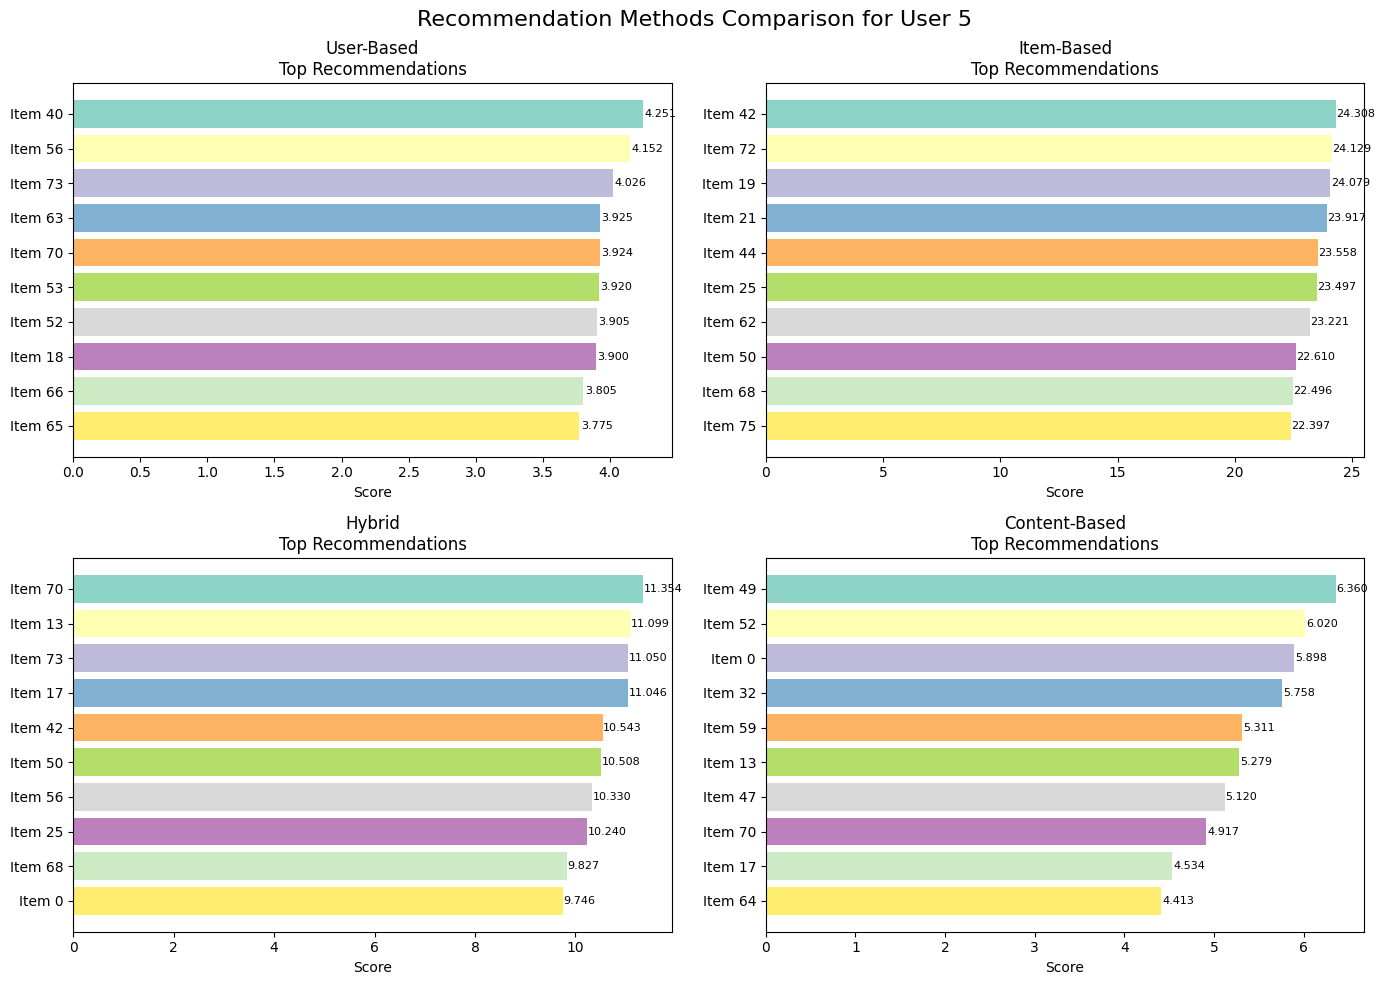


Visualizing hybrid recommendations with item details...


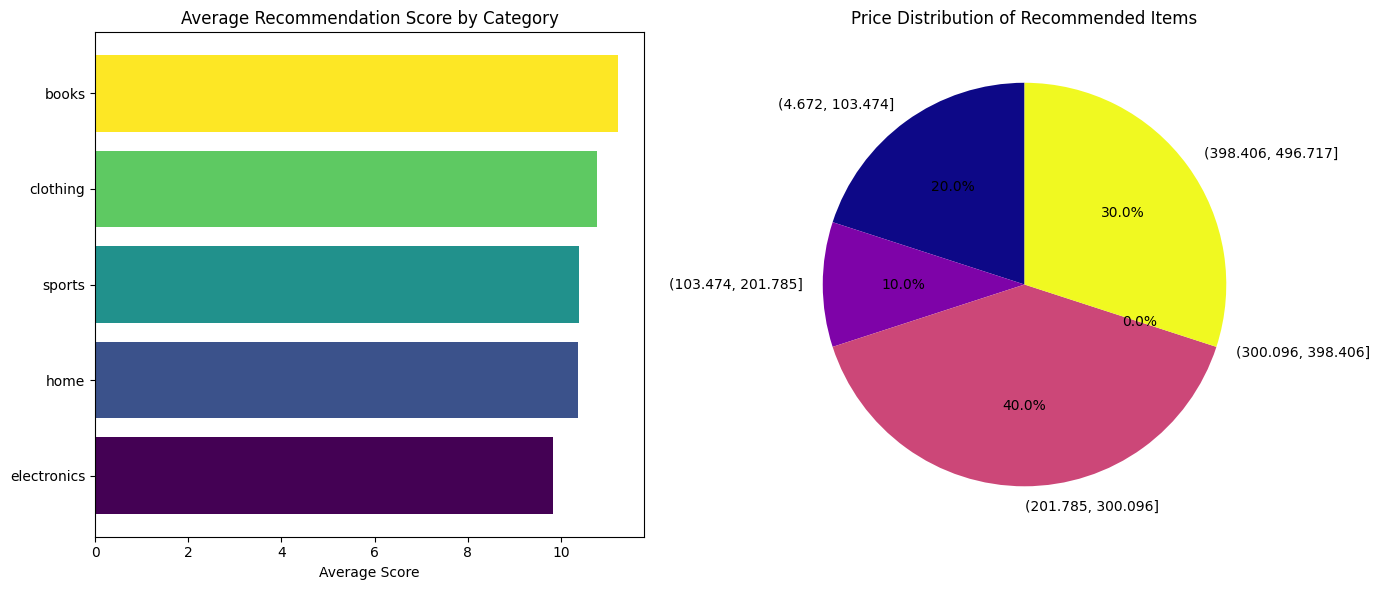


8. MODEL EVALUATION

Retraining models on training data...
Training User-Based k-NN with k=15, similarity=cosine
Computed similarities for 150 users
Training Item-Based k-NN with k=15, similarity=cosine
Computed similarities for 80 items

Evaluating predictions on test data...

User-Based k-NN Evaluation:
  MAE: 1.012
  RMSE: 1.182
  Coverage: 100.00%
  Predictions made: 100

Item-Based k-NN Evaluation:
  MAE: 0.975
  RMSE: 1.188
  Coverage: 100.00%
  Predictions made: 100

9. PRACTICAL USE CASES

A. 'Users who liked this also liked...' (Item-Based):
  For Item 3 (books):
    • Item 58 (books): similarity 0.463
    • Item 25 (home): similarity 0.406
    • Item 12 (home): similarity 0.393

B. Cold Start Recommendation (Content-Based):
  For new item 80 (no interactions yet):
    • Recommend Item 39 (sports): similarity 0.993
    • Recommend Item 46 (sports): similarity 0.962
    • Recommend Item 17 (sports): similarity 0.945

C. Personalized Homepage (Hybrid):
  Personalized recommenda

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, lil_matrix
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union, Optional
import warnings
warnings.filterwarnings('ignore')

print("All imports successful!")

# ============================================
# 1. ГЕНЕРАЦИЯ ДАННЫХ
# ============================================

def generate_recommendation_data(n_users=200, n_items=100, sparsity=0.7):
    """Генерация данных для рекомендательной системы"""
    np.random.seed(42)

    # Создаем разреженную матрицу взаимодействий
    data = []
    for user in range(n_users):
        for item in range(n_items):
            if np.random.random() > sparsity:  # 30% density
                rating = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.15, 0.2, 0.3, 0.25])
                data.append([user, item, rating])

    df = pd.DataFrame(data, columns=['user_id', 'item_id', 'rating'])

    # Добавляем признаки пользователей
    user_features = {
        'user_id': range(n_users),
        'age': np.random.randint(18, 65, n_users),
        'gender': np.random.choice(['M', 'F'], n_users, p=[0.55, 0.45]),
        'location': np.random.choice(['NY', 'LA', 'SF', 'CH', 'MI'], n_users),
    }

    # Добавляем признаки товаров
    categories = ['electronics', 'books', 'clothing', 'home', 'sports', 'beauty']
    item_features = {
        'item_id': range(n_items),
        'category': np.random.choice(categories, n_items),
        'price': np.random.uniform(5, 500, n_items),
        'popularity': np.random.randint(1, 1000, n_items),
    }

    user_df = pd.DataFrame(user_features)
    item_df = pd.DataFrame(item_features)

    return df, user_df, item_df

# ============================================
# 2. USER-BASED k-NN
# ============================================

class UserBasedKNN:
    """
    User-Based Collaborative Filtering с k-NN
    Рекомендации на основе схожести пользователей
    """

    def __init__(self, k=20, similarity='cosine', min_similarity=0.1):
        """
        Args:
            k: количество ближайших соседей
            similarity: метрика схожести ('cosine', 'pearson', 'euclidean')
            min_similarity: минимальная схожесть для учета
        """
        self.k = k
        self.similarity = similarity
        self.min_similarity = min_similarity
        self.user_similarities = None
        self.user_item_matrix = None
        self.user_ids = None
        self.item_ids = None

    def fit(self, interactions_df: pd.DataFrame):
        """Обучение модели"""
        print(f"Training User-Based k-NN with k={self.k}, similarity={self.similarity}")

        # Создаем user-item матрицу
        self.user_item_matrix = interactions_df.pivot_table(
            index='user_id',
            columns='item_id',
            values='rating',
            fill_value=0
        )

        self.user_ids = self.user_item_matrix.index.tolist()
        self.item_ids = self.user_item_matrix.columns.tolist()

        # Вычисляем схожесть между пользователями
        if self.similarity == 'cosine':
            self.user_similarities = cosine_similarity(self.user_item_matrix.values)
        elif self.similarity == 'pearson':
            # Центрируем данные для Pearson correlation
            user_means = self.user_item_matrix.mean(axis=1)
            centered = self.user_item_matrix.sub(user_means, axis=0)
            self.user_similarities = np.corrcoef(centered.fillna(0).values)
        elif self.similarity == 'euclidean':
            distances = euclidean_distances(self.user_item_matrix.values)
            # Преобразуем расстояния в схожести
            self.user_similarities = 1 / (1 + distances)
        else:
            raise ValueError(f"Unknown similarity: {self.similarity}")

        # Заменяем NaN значения
        np.fill_diagonal(self.user_similarities, 0)  # Схожесть с самим собой = 0
        self.user_similarities = np.nan_to_num(self.user_similarities)

        print(f"Computed similarities for {len(self.user_ids)} users")
        return self

    def predict(self, user_id: int, item_id: int) -> float:
        """Предсказание рейтинга для конкретного пользователя и товара"""
        if user_id not in self.user_ids or item_id not in self.item_ids:
            return 0.0

        user_idx = self.user_ids.index(user_id)
        item_idx = self.item_ids.index(item_id)

        # Получаем схожести текущего пользователя со всеми
        user_sims = self.user_similarities[user_idx]

        # Находим k ближайших соседей, которые оценили этот товар
        neighbor_indices = []
        neighbor_similarities = []

        for other_idx, sim in enumerate(user_sims):
            if sim > self.min_similarity and other_idx != user_idx:
                # Проверяем, оценил ли сосед этот товар
                rating = self.user_item_matrix.iloc[other_idx, item_idx]
                if rating > 0:
                    neighbor_indices.append(other_idx)
                    neighbor_similarities.append(sim)

        if not neighbor_indices:
            return 0.0

        # Берем топ-k соседей по схожести
        if len(neighbor_indices) > self.k:
            top_k_idx = np.argsort(neighbor_similarities)[-self.k:]
            neighbor_indices = [neighbor_indices[i] for i in top_k_idx]
            neighbor_similarities = [neighbor_similarities[i] for i in top_k_idx]

        # Предсказываем рейтинг как взвешенное среднее
        numerator = 0
        denominator = 0

        for idx, sim in zip(neighbor_indices, neighbor_similarities):
            rating = self.user_item_matrix.iloc[idx, item_idx]
            numerator += sim * rating
            denominator += abs(sim)

        if denominator == 0:
            return 0.0

        predicted_rating = numerator / denominator
        return min(max(predicted_rating, 1), 5)  # Ограничиваем диапазоном 1-5

    def recommend(self, user_id: int, top_n: int = 10) -> List[Tuple[int, float]]:
        """Рекомендация товаров для пользователя"""
        if user_id not in self.user_ids:
            return []

        user_idx = self.user_ids.index(user_id)

        # Получаем все товары
        all_items = self.item_ids

        # Предсказываем рейтинг для всех товаров, которые пользователь еще не оценивал
        predictions = []
        user_rated_items = set(
            self.user_item_matrix.columns[
                self.user_item_matrix.iloc[user_idx] > 0
            ].tolist()
        )

        for item_id in all_items:
            if item_id not in user_rated_items:
                pred = self.predict(user_id, item_id)
                if pred > 0:
                    predictions.append((item_id, pred))

        # Сортируем по убыванию предсказанного рейтинга
        predictions.sort(key=lambda x: x[1], reverse=True)

        return predictions[:top_n]

    def get_similar_users(self, user_id: int, top_k: int = 5) -> List[Tuple[int, float]]:
        """Получение наиболее похожих пользователей"""
        if user_id not in self.user_ids:
            return []

        user_idx = self.user_ids.index(user_id)
        similarities = self.user_similarities[user_idx]

        # Исключаем самого пользователя
        similarities[user_idx] = -1

        # Находим топ-k
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        similar_users = []
        for idx in top_indices:
            if similarities[idx] > self.min_similarity:
                similar_users.append((self.user_ids[idx], similarities[idx]))

        return similar_users

# ============================================
# 3. ITEM-BASED k-NN
# ============================================

class ItemBasedKNN:
    """
    Item-Based Collaborative Filtering с k-NN
    Рекомендации на основе схожести товаров
    """

    def __init__(self, k=20, similarity='cosine', min_similarity=0.1):
        self.k = k
        self.similarity = similarity
        self.min_similarity = min_similarity
        self.item_similarities = None
        self.user_item_matrix = None
        self.user_ids = None
        self.item_ids = None

    def fit(self, interactions_df: pd.DataFrame):
        """Обучение модели"""
        print(f"Training Item-Based k-NN with k={self.k}, similarity={self.similarity}")

        # Создаем user-item матрицу (транспонированную для item-based)
        self.user_item_matrix = interactions_df.pivot_table(
            index='user_id',
            columns='item_id',
            values='rating',
            fill_value=0
        )

        self.user_ids = self.user_item_matrix.index.tolist()
        self.item_ids = self.user_item_matrix.columns.tolist()

        # Транспонируем для вычисления схожести между товарами
        item_user_matrix = self.user_item_matrix.T

        # Вычисляем схожесть между товарами
        if self.similarity == 'cosine':
            self.item_similarities = cosine_similarity(item_user_matrix.values)
        elif self.similarity == 'adjusted_cosine':
            # Adjusted cosine: учитываем средние рейтинги пользователей
            user_means = self.user_item_matrix.mean(axis=1)
            centered = self.user_item_matrix.sub(user_means, axis=0)
            self.item_similarities = cosine_similarity(centered.T.fillna(0).values)
        elif self.similarity == 'euclidean':
            distances = euclidean_distances(item_user_matrix.values)
            self.item_similarities = 1 / (1 + distances)
        else:
            raise ValueError(f"Unknown similarity: {self.similarity}")

        np.fill_diagonal(self.item_similarities, 0)
        self.item_similarities = np.nan_to_num(self.item_similarities)

        print(f"Computed similarities for {len(self.item_ids)} items")
        return self

    def predict(self, user_id: int, item_id: int) -> float:
        """Предсказание рейтинга"""
        if user_id not in self.user_ids or item_id not in self.item_ids:
            return 0.0

        user_idx = self.user_ids.index(user_id)
        item_idx = self.item_ids.index(item_id)

        # Получаем схожести текущего товара со всеми
        item_sims = self.item_similarities[item_idx]

        # Находим k ближайших товаров, которые пользователь оценил
        neighbor_indices = []
        neighbor_similarities = []

        for other_idx, sim in enumerate(item_sims):
            if sim > self.min_similarity and other_idx != item_idx:
                rating = self.user_item_matrix.iloc[user_idx, other_idx]
                if rating > 0:
                    neighbor_indices.append(other_idx)
                    neighbor_similarities.append(sim)

        if not neighbor_indices:
            return 0.0

        # Берем топ-k соседей
        if len(neighbor_indices) > self.k:
            top_k_idx = np.argsort(neighbor_similarities)[-self.k:]
            neighbor_indices = [neighbor_indices[i] for i in top_k_idx]
            neighbor_similarities = [neighbor_similarities[i] for i in top_k_idx]

        # Предсказываем рейтинг
        numerator = 0
        denominator = 0

        for idx, sim in zip(neighbor_indices, neighbor_similarities):
            rating = self.user_item_matrix.iloc[user_idx, idx]
            numerator += sim * rating
            denominator += abs(sim)

        if denominator == 0:
            return 0.0

        predicted_rating = numerator / denominator
        return min(max(predicted_rating, 1), 5)

    def recommend(self, user_id: int, top_n: int = 10) -> List[Tuple[int, float]]:
        """Рекомендация товаров для пользователя"""
        if user_id not in self.user_ids:
            return []

        user_idx = self.user_ids.index(user_id)

        # Товары, которые пользователь уже оценил
        user_ratings = self.user_item_matrix.iloc[user_idx]
        rated_items = user_ratings[user_ratings > 0].index.tolist()

        # Для каждого оцененного товара находим похожие
        candidate_scores = {}

        for rated_item in rated_items:
            rated_rating = user_ratings[rated_item]
            rated_idx = self.item_ids.index(rated_item)

            # Получаем схожести этого товара
            similarities = self.item_similarities[rated_idx]

            # Для каждого похожего товара добавляем score
            for other_idx, sim in enumerate(similarities):
                if sim > self.min_similarity:
                    other_item = self.item_ids[other_idx]

                    # Пропускаем уже оцененные
                    if other_item in rated_items:
                        continue

                    # Score = схожесть * рейтинг
                    score = sim * rated_rating

                    if other_item not in candidate_scores:
                        candidate_scores[other_item] = 0
                    candidate_scores[other_item] += score

        # Сортируем по убыванию score
        recommendations = sorted(
            candidate_scores.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_n]

        return recommendations

    def get_similar_items(self, item_id: int, top_k: int = 5) -> List[Tuple[int, float]]:
        """Получение наиболее похожих товаров"""
        if item_id not in self.item_ids:
            return []

        item_idx = self.item_ids.index(item_id)
        similarities = self.item_similarities[item_idx]

        similarities[item_idx] = -1
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        similar_items = []
        for idx in top_indices:
            if similarities[idx] > self.min_similarity:
                similar_items.append((self.item_ids[idx], similarities[idx]))

        return similar_items

# ============================================
# 4. CONTENT-BASED k-NN
# ============================================

class ContentBasedKNN:
    """
    Content-Based Filtering с k-NN
    Рекомендации на основе схожести атрибутов товаров
    """

    def __init__(self, k=20, similarity='cosine'):
        self.k = k
        self.similarity = similarity
        self.item_features = None
        self.item_ids = None
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()

    def prepare_features(self, item_df: pd.DataFrame, categorical_cols: List[str],
                        numerical_cols: List[str]):
        """Подготовка признаков товаров"""
        features_df = item_df.copy()

        # One-hot encoding категориальных признаков
        for col in categorical_cols:
            if col in features_df.columns:
                dummies = pd.get_dummies(features_df[col], prefix=col)
                features_df = pd.concat([features_df, dummies], axis=1)
                features_df = features_df.drop(col, axis=1)

        # Масштабирование числовых признаков
        if numerical_cols:
            features_df[numerical_cols] = self.scaler.fit_transform(
                features_df[numerical_cols]
            )

        self.item_ids = features_df['item_id'].values
        self.item_features = features_df.drop('item_id', axis=1).values

        print(f"Prepared features for {len(self.item_ids)} items")
        print(f"Feature dimension: {self.item_features.shape[1]}")

        return self

    def fit(self, item_df: pd.DataFrame, categorical_cols: List[str],
            numerical_cols: List[str]):
        """Обучение модели"""
        print(f"Training Content-Based k-NN with k={self.k}")
        self.prepare_features(item_df, categorical_cols, numerical_cols)
        return self

    def get_similar_items(self, item_id: int, top_k: int = 10) -> List[Tuple[int, float]]:
        """Получение наиболее похожих товаров по контенту"""
        if item_id not in self.item_ids:
            return []

        item_idx = np.where(self.item_ids == item_id)[0][0]
        item_vector = self.item_features[item_idx].reshape(1, -1)

        # Вычисляем схожесть со всеми товарами
        if self.similarity == 'cosine':
            similarities = cosine_similarity(item_vector, self.item_features)[0]
        elif self.similarity == 'euclidean':
            distances = euclidean_distances(item_vector, self.item_features)[0]
            similarities = 1 / (1 + distances)
        else:
            raise ValueError(f"Unknown similarity: {self.similarity}")

        # Исключаем сам товар
        similarities[item_idx] = -1

        # Находим топ-k
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        similar_items = []
        for idx in top_indices:
            if similarities[idx] > 0:
                similar_items.append((self.item_ids[idx], similarities[idx]))

        return similar_items

    def recommend_for_user(self, user_history: List[int], top_n: int = 10) -> List[Tuple[int, float]]:
        """Рекомендация товаров на основе истории пользователя"""
        if not user_history:
            return []

        # Собираем похожие товары для всей истории
        candidate_scores = {}

        for item_id in user_history:
            similar_items = self.get_similar_items(item_id, top_k=20)

            for similar_item, similarity in similar_items:
                # Пропускаем товары из истории
                if similar_item in user_history:
                    continue

                if similar_item not in candidate_scores:
                    candidate_scores[similar_item] = 0
                candidate_scores[similar_item] += similarity

        # Сортируем по убыванию score
        recommendations = sorted(
            candidate_scores.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_n]

        return recommendations

# ============================================
# 5. ГИБРИДНЫЙ k-NN
# ============================================

class HybridKNN:
    """
    Гибридный k-NN, комбинирующий разные подходы
    """

    def __init__(self, user_knn: UserBasedKNN, item_knn: ItemBasedKNN,
                 content_knn: ContentBasedKNN, weights=None):
        self.user_knn = user_knn
        self.item_knn = item_knn
        self.content_knn = content_knn
        self.weights = weights or {'user': 0.4, 'item': 0.4, 'content': 0.2}

        # Нормализуем веса
        total = sum(self.weights.values())
        self.weights = {k: v/total for k, v in self.weights.items()}

    def recommend(self, user_id: int, user_history: List[int] = None,
                  top_n: int = 10) -> List[Tuple[int, float]]:
        """Гибридные рекомендации"""
        # 1. User-Based рекомендации
        user_recs = self.user_knn.recommend(user_id, top_n=top_n*2)
        user_scores = {item: score * self.weights['user'] for item, score in user_recs}

        # 2. Item-Based рекомендации
        item_recs = self.item_knn.recommend(user_id, top_n=top_n*2)
        item_scores = {item: score * self.weights['item'] for item, score in item_recs}

        # 3. Content-Based рекомендации
        content_scores = {}
        if user_history:
            content_recs = self.content_knn.recommend_for_user(user_history, top_n=top_n*2)
            content_scores = {item: score * self.weights['content'] for item, score in content_recs}

        # Комбинируем scores
        combined_scores = {}

        # Объединяем все рекомендации
        all_items = set(list(user_scores.keys()) +
                       list(item_scores.keys()) +
                       list(content_scores.keys()))

        for item in all_items:
            total_score = 0
            total_score += user_scores.get(item, 0)
            total_score += item_scores.get(item, 0)
            total_score += content_scores.get(item, 0)
            combined_scores[item] = total_score

        # Сортируем по убыванию score
        recommendations = sorted(
            combined_scores.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_n]

        return recommendations

# ============================================
# 6. ВИЗУАЛИЗАЦИЯ И АНАЛИЗ
# ============================================

class KNNVisualizer:
    """Визуализация результатов k-NN"""

    @staticmethod
    def plot_similarity_matrix(similarity_matrix, title, labels=None):
        """Визуализация матрицы схожести"""
        plt.figure(figsize=(10, 8))
        plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
        plt.colorbar(label='Similarity')
        plt.title(title)
        plt.xlabel('Index')
        plt.ylabel('Index')

        if labels is not None and len(labels) <= 20:
            plt.xticks(range(len(labels)), labels, rotation=90)
            plt.yticks(range(len(labels)), labels)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_recommendations(recommendations, title, item_names=None):
        """Визуализация рекомендаций"""
        items, scores = zip(*recommendations)

        if item_names:
            item_labels = [item_names.get(item, f"Item {item}") for item in items]
        else:
            item_labels = [f"Item {item}" for item in items]

        plt.figure(figsize=(12, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, len(items)))
        bars = plt.barh(item_labels, scores, color=colors)
        plt.gca().invert_yaxis()
        plt.title(title)
        plt.xlabel('Recommendation Score')

        # Добавляем значения
        for bar, score in zip(bars, scores):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{score:.3f}', va='center')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_comparison(methods_results, title):
        """Сравнение разных методов"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()

        for idx, (method_name, results) in enumerate(methods_results.items()):
            if idx >= len(axes):
                break

            items, scores = zip(*results[:10])  # Берем топ-10
            item_labels = [f"Item {item}" for item in items]

            colors = plt.cm.Set3(np.linspace(0, 1, len(items)))
            bars = axes[idx].barh(item_labels, scores, color=colors)
            axes[idx].invert_yaxis()
            axes[idx].set_title(f'{method_name}\nTop Recommendations')
            axes[idx].set_xlabel('Score')

            # Добавляем значения
            for bar, score in zip(bars, scores):
                axes[idx].text(bar.get_width() + 0.01,
                              bar.get_y() + bar.get_height()/2,
                              f'{score:.3f}', va='center', fontsize=8)

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

# ============================================
# 7. ДЕМОНСТРАЦИЯ РАБОТЫ
# ============================================
from sklearn.model_selection import train_test_split
def main():
    print("=" * 80)
    print("k-NN FOR RECOMMENDER SYSTEMS - COMPREHENSIVE DEMONSTRATION")
    print("=" * 80)

    # 1. Генерация данных
    print("\n1. Generating data...")
    interactions_df, user_df, item_df = generate_recommendation_data(
        n_users=150, n_items=80, sparsity=0.7
    )


    print(f"Interactions: {len(interactions_df)} ratings")
    print(f"Users: {len(user_df)}")
    print(f"Items: {len(item_df)}")
    print(f"Sparsity: {(len(interactions_df) / (150*80))*100:.1f}%")

    # Пример данных
    print("\nSample interactions:")
    print(interactions_df.head())
    print("\nSample items:")
    print(item_df.head())

    # 2. Обучение разных k-NN моделей
    print("\n" + "="*80)
    print("2. TRAINING DIFFERENT k-NN MODELS")
    print("="*80)

    # User-Based k-NN
    print("\nTraining User-Based k-NN...")
    user_knn = UserBasedKNN(k=15, similarity='cosine', min_similarity=0.1)
    user_knn.fit(interactions_df)

    # Item-Based k-NN
    print("\nTraining Item-Based k-NN...")
    item_knn = ItemBasedKNN(k=15, similarity='cosine', min_similarity=0.1)
    item_knn.fit(interactions_df)

    # Content-Based k-NN
    print("\nTraining Content-Based k-NN...")
    content_knn = ContentBasedKNN(k=15, similarity='cosine')
    content_knn.fit(item_df,
                   categorical_cols=['category'],
                   numerical_cols=['price', 'popularity'])

    # 3. Тестирование на конкретном пользователе
    print("\n" + "="*80)
    print("3. TESTING ON SPECIFIC USER")
    print("="*80)

    test_user_id = 5
    print(f"\nAnalyzing recommendations for User {test_user_id}")

    # История пользователя
    user_history = interactions_df[interactions_df['user_id'] == test_user_id]
    user_rated_items = user_history['item_id'].tolist()

    print(f"User {test_user_id} has rated {len(user_rated_items)} items:")
    for _, row in user_history.head().iterrows():
        print(f"  Item {row['item_id']}: Rating {row['rating']}")

    # 4. Получение рекомендаций разными методами
    print("\n" + "="*80)
    print("4. GETTING RECOMMENDATIONS")
    print("="*80)

    # User-Based рекомендации
    print("\nUser-Based recommendations:")
    user_recs = user_knn.recommend(test_user_id, top_n=10)
    for i, (item_id, score) in enumerate(user_recs, 1):
        print(f"  {i}. Item {item_id}: Score {score:.3f}")

    # Item-Based рекомендации
    print("\nItem-Based recommendations:")
    item_recs = item_knn.recommend(test_user_id, top_n=10)
    for i, (item_id, score) in enumerate(item_recs, 1):
        print(f"  {i}. Item {item_id}: Score {score:.3f}")

    # Content-Based рекомендации
    print("\nContent-Based recommendations (based on user history):")
    if user_rated_items:
        content_recs = content_knn.recommend_for_user(user_rated_items, top_n=10)
        for i, (item_id, score) in enumerate(content_recs, 1):
            print(f"  {i}. Item {item_id}: Score {score:.3f}")

    # 5. Гибридные рекомендации
    print("\n" + "="*80)
    print("5. HYBRID RECOMMENDATIONS")
    print("="*80)

    hybrid_knn = HybridKNN(
        user_knn=user_knn,
        item_knn=item_knn,
        content_knn=content_knn,
        weights={'user': 0.4, 'item': 0.4, 'content': 0.2}
    )

    hybrid_recs = hybrid_knn.recommend(
        user_id=test_user_id,
        user_history=user_rated_items,
        top_n=10
    )

    print("\nHybrid recommendations:")
    for i, (item_id, score) in enumerate(hybrid_recs, 1):
        item_category = item_df[item_df['item_id'] == item_id]['category'].iloc[0]
        print(f"  {i}. Item {item_id} ({item_category}): Score {score:.3f}")

    # 6. Похожие пользователи и товары
    print("\n" + "="*80)
    print("6. SIMILAR USERS AND ITEMS")
    print("="*80)

    # Похожие пользователи
    print(f"\nUsers similar to User {test_user_id}:")
    similar_users = user_knn.get_similar_users(test_user_id, top_k=5)
    for user_id, similarity in similar_users:
        user_age = user_df[user_df['user_id'] == user_id]['age'].iloc[0]
        user_gender = user_df[user_df['user_id'] == user_id]['gender'].iloc[0]
        print(f"  User {user_id} (Age: {user_age}, Gender: {user_gender}): "
              f"Similarity {similarity:.3f}")

    # Похожие товары (из истории пользователя)
    if user_rated_items:
        test_item = user_rated_items[0]
        item_category = item_df[item_df['item_id'] == test_item]['category'].iloc[0]
        item_price = item_df[item_df['item_id'] == test_item]['price'].iloc[0]

        print(f"\nItems similar to Item {test_item} ({item_category}, ${item_price:.2f}):")

        # Item-Based похожие товары
        item_similar_items = item_knn.get_similar_items(test_item, top_k=5)
        print("  Item-Based similar items:")
        for item_id, similarity in item_similar_items:
            category = item_df[item_df['item_id'] == item_id]['category'].iloc[0]
            print(f"    Item {item_id} ({category}): Similarity {similarity:.3f}")

        # Content-Based похожие товары
        content_similar_items = content_knn.get_similar_items(test_item, top_k=5)
        print("  Content-Based similar items:")
        for item_id, similarity in content_similar_items:
            category = item_df[item_df['item_id'] == item_id]['category'].iloc[0]
            print(f"    Item {item_id} ({category}): Similarity {similarity:.3f}")

    # 7. Визуализация
    print("\n" + "="*80)
    print("7. VISUALIZATION")
    print("="*80)

    visualizer = KNNVisualizer()

    # Визуализация рекомендаций
    methods_results = {
        'User-Based': user_recs,
        'Item-Based': item_recs,
        'Hybrid': hybrid_recs
    }

    if user_rated_items:
        methods_results['Content-Based'] = content_recs

    visualizer.plot_comparison(
        methods_results,
        f'Recommendation Methods Comparison for User {test_user_id}'
    )

    # Визуализация отдельных рекомендаций
    print("\nVisualizing hybrid recommendations with item details...")

    detailed_recs = []
    for item_id, score in hybrid_recs:
        category = item_df[item_df['item_id'] == item_id]['category'].iloc[0]
        price = item_df[item_df['item_id'] == item_id]['price'].iloc[0]
        detailed_recs.append((item_id, score, category, price))

    # Создаем DataFrame для красивой визуализации
    recs_df = pd.DataFrame(detailed_recs,
                          columns=['item_id', 'score', 'category', 'price'])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # График 1: Scores по категориям
    category_scores = recs_df.groupby('category')['score'].mean().sort_values()
    colors1 = plt.cm.viridis(np.linspace(0, 1, len(category_scores)))
    axes[0].barh(category_scores.index, category_scores.values, color=colors1)
    axes[0].set_title('Average Recommendation Score by Category')
    axes[0].set_xlabel('Average Score')

    # График 2: Цены рекомендованных товаров
    price_bins = pd.cut(recs_df['price'], bins=5)
    price_dist = recs_df.groupby(price_bins).size()

    colors2 = plt.cm.plasma(np.linspace(0, 1, len(price_dist)))
    wedges, texts, autotexts = axes[1].pie(price_dist.values, labels=price_dist.index,
                                          autopct='%1.1f%%', colors=colors2, startangle=90)
    axes[1].set_title('Price Distribution of Recommended Items')

    plt.tight_layout()
    plt.show()

    # 8. Оценка качества
    print("\n" + "="*80)
    print("8. MODEL EVALUATION")
    print("="*80)

    # ИМПОРТИРУЕМ train_test_split здесь если не импортировали глобально
    from sklearn.model_selection import train_test_split

    # Разделяем данные на train/test
    train_df, test_df = train_test_split(
        interactions_df, test_size=0.2, random_state=42
    )

    # Переобучаем на train данных
    print("\nRetraining models on training data...")
    user_knn_train = UserBasedKNN(k=15, similarity='cosine')
    user_knn_train.fit(train_df)

    item_knn_train = ItemBasedKNN(k=15, similarity='cosine')
    item_knn_train.fit(train_df)

    # Оцениваем на test данных
    print("\nEvaluating predictions on test data...")

    def evaluate_model(model, test_data, sample_size=50):
        """Оценка модели на test данных"""
        errors = []
        sampled = test_data.sample(min(sample_size, len(test_data)), random_state=42)

        for _, row in sampled.iterrows():
            user_id = row['user_id']
            item_id = row['item_id']
            actual_rating = row['rating']

            predicted_rating = model.predict(user_id, item_id)

            if predicted_rating > 0:
                error = abs(predicted_rating - actual_rating)
                errors.append(error)

        if errors:
            mae = np.mean(errors)
            rmse = np.sqrt(np.mean([e**2 for e in errors]))
            coverage = len(errors) / len(sampled)

            return {
                'MAE': mae,
                'RMSE': rmse,
                'Coverage': coverage,
                'Num_Predictions': len(errors)
            }
        return None

    # Оценка User-Based k-NN
    user_eval = evaluate_model(user_knn_train, test_df, sample_size=100)
    if user_eval:
        print(f"\nUser-Based k-NN Evaluation:")
        print(f"  MAE: {user_eval['MAE']:.3f}")
        print(f"  RMSE: {user_eval['RMSE']:.3f}")
        print(f"  Coverage: {user_eval['Coverage']:.2%}")
        print(f"  Predictions made: {user_eval['Num_Predictions']}")

    # Оценка Item-Based k-NN
    item_eval = evaluate_model(item_knn_train, test_df, sample_size=100)
    if item_eval:
        print(f"\nItem-Based k-NN Evaluation:")
        print(f"  MAE: {item_eval['MAE']:.3f}")
        print(f"  RMSE: {item_eval['RMSE']:.3f}")
        print(f"  Coverage: {item_eval['Coverage']:.2%}")
        print(f"  Predictions made: {item_eval['Num_Predictions']}")

    # 9. Практические примеры использования
    print("\n" + "="*80)
    print("9. PRACTICAL USE CASES")
    print("="*80)

    print("\nA. 'Users who liked this also liked...' (Item-Based):")
    if user_rated_items:
        example_item = user_rated_items[0]
        similar = item_knn.get_similar_items(example_item, top_k=3)
        item_name = item_df[item_df['item_id'] == example_item]['category'].iloc[0]
        print(f"  For Item {example_item} ({item_name}):")
        for item_id, similarity in similar:
            category = item_df[item_df['item_id'] == item_id]['category'].iloc[0]
            print(f"    • Item {item_id} ({category}): similarity {similarity:.3f}")

    print("\nB. Cold Start Recommendation (Content-Based):")
    new_item_id = max(item_df['item_id']) + 1
    print(f"  For new item {new_item_id} (no interactions yet):")
    # Используем контентные признаки похожего товара
    if len(item_df) > 0:
        base_item = item_df['item_id'].iloc[0]
        similar_new = content_knn.get_similar_items(base_item, top_k=3)
        for item_id, similarity in similar_new:
            category = item_df[item_df['item_id'] == item_id]['category'].iloc[0]
            print(f"    • Recommend Item {item_id} ({category}): similarity {similarity:.3f}")

    print("\nC. Personalized Homepage (Hybrid):")
    print(f"  Personalized recommendations for User {test_user_id}:")
    for i, (item_id, score) in enumerate(hybrid_recs[:3], 1):
        category = item_df[item_df['item_id'] == item_id]['category'].iloc[0]
        price = item_df[item_df['item_id'] == item_id]['price'].iloc[0]
        print(f"    {i}. Item {item_id} - {category} (${price:.2f}): score {score:.3f}")

    # 10. Заключение
    print("\n" + "="*80)
    print("CONCLUSION")
    print("="*80)

    print("\nSummary of k-NN methods for recommender systems:")
    print("1. User-Based k-NN:")
    print("   • Pros: Good for social recommendations, captures user tastes")
    print("   • Cons: Cold start problem, scalability issues")

    print("\n2. Item-Based k-NN:")
    print("   • Pros: More stable, handles new users better")
    print("   • Cons: Needs item similarity computation")

    print("\n3. Content-Based k-NN:")
    print("   • Pros: Solves cold start, explainable recommendations")
    print("   • Cons: Limited by feature quality, no serendipity")

    print("\n4. Hybrid k-NN:")
    print("   • Pros: Best of all worlds, robust recommendations")
    print("   • Cons: More complex, requires tuning")

    print("\nProduction recommendations:")
    print("• Start with Item-Based k-NN for stability")
    print("• Add Content-Based for cold start")
    print("• Use Hybrid for personalized experiences")
    print("• Consider scalability with approximate k-NN (Annoy, FAISS)")

    print("\n" + "="*80)
    print("k-NN DEMONSTRATION COMPLETE!")
    print("=" * 80)

# Запуск демонстрации
if __name__ == "__main__":
    main()